#### Ribbit <font color = '#8fc3cf'>(Image Upscaler)</font>
<img src="dalle1.png" alt="Ribbit" width="500"/>


## <font color = '#c199d1'>Importing</font>
- pandas - reading and manipulating data
- numpy 
- torch.nn - gives the model structure
- PIL (image) - reading image file
- torchvision (transforms) - preprocess image to tensor

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import torch.optim.lr_scheduler as lr_scheduler

### Setting device as GPU

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Structuring and Processing data
1. We have taken a High resolution subset of the dataset DIV2K
2. Due to the restriction of low compute power we want to use smaller images than the ones given in the dataset
3. We crop each image into several 256 x 256 size images, saved in the train_HR folder. These images will be used<br> as the high resolution images
4. Now we resize all the images 4 (scale_factor) times smaller to 64 x 64, saved in the train_LR folder. These are<br> the low resolution images

### create folders

In [3]:
source_folder = 'DIV2K/HR'
target_hr_folder = 'dataset/train_HR'
target_lr_folder = 'dataset/train_LR'
data_dir = 'data_dir'

hr_images_dir = 'dataset/train_HR'
lr_images_dir = 'dataset/train_LR'

In [4]:
os.makedirs(target_hr_folder, exist_ok = True)
os.makedirs(target_lr_folder, exist_ok = True)
os.makedirs(data_dir, exist_ok = True)

### Defining scales needed to reshape and create dataset

In [8]:
crop_size = 256
scale_factor = 4
lr_crop_size = crop_size // scale_factor

### Looping through all images and creating the dataset accordingly  <font color='red'>( Don't Run U dumb mf )</font>

### Combining into a single folder for preprocessing <font color = 'red'>( This neither )</font>

## Preprocessing

In [9]:
class CustomDataset(Dataset):
    def __init__(self, hr_dir, lr_dir):
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.image_files = [f for f in os.listdir(lr_dir) if f.endswith('_LR.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        lr_path = os.path.join(self.lr_dir, self.image_files[idx])
        hr_path = os.path.join(self.hr_dir, self.image_files[idx].replace('_LR.png', '_HR.png'))

        lr_image = Image.open(lr_path).convert('RGB')
        hr_image = Image.open(hr_path).convert('RGB')

        transform = transforms.Compose([transforms.ToTensor()])
        lr_image = transform(lr_image)
        hr_image = transform(hr_image)

        return lr_image, hr_image


### Applying Preprocessing

In [10]:
dataset = CustomDataset(hr_images_dir, lr_images_dir)

In [11]:
len(dataset)

27958

### Creating the Data Loader

In [12]:
batch_size = 8 
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

In [13]:
data_loader

## MODELS
- SPGAN needs a Generator and Discriminator
- The usage of pixel shuffle made me realise something. Though I had understood this before, it never felt this explicit.
- The learning part of the generator doesn't really create the super resolution image, the pixel shuffle does. The model doesn't need to learn how to create the final output in this case, but it could be so much more. The model learns how to create the appropriate values to 

### Generator

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 1)
        self.bnorm1 = nn.BatchNorm2d(32)
        self.prelu1 = nn.PReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.bnorm2 = nn.BatchNorm2d(64)
        self.prelu2 = nn.PReLU()
        self.conv3 = nn.Conv2d(64, 3 * scale_factor**2, kernel_size=3, stride=1, padding=1)
        self.pixelshuffle = nn.PixelShuffle(scale_factor)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bnorm1(x)
        x = self.prelu1(x)
        x = self.conv2(x)
        x = self.bnorm2(x)
        x = self.prelu2(x)
        x = self.conv3(x)
        x = self.pixelshuffle(x)

        return x

In [15]:
generator = Generator().to(device)

### Discriminator

In [16]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 4, stride = 2, padding = 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.leaky_relu1 = nn.LeakyReLU(0.2, inplace = True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 4, stride = 2, padding = 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.leaky_relu2 = nn.LeakyReLU(0.2, inplace = True)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.leaky_relu3 = nn.LeakyReLU(0.2, inplace = True)
        self.conv4 = nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1)
        self.bn4 = nn.BatchNorm2d(256)
        self.leaky_relu4 = nn.LeakyReLU(0.2, inplace = True)
        self.conv5 = nn.Conv2d(256, 1, kernel_size = 4, stride = 2, padding = 0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leaky_relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.leaky_relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.leaky_relu4(x)
        x = self.conv5(x)
        x = self.sigmoid(x)
        
        return x
        

In [17]:
discriminator =  Discriminator().to(device)

## Training

In [19]:
criterion_MSE = nn.MSELoss()
criterion_BCE = nn.BCELoss()
learning_rate = 2e-4
num_epochs = 100
lambda_adv = 0.01

In [20]:
optimizer_D = optim.Adam( discriminator.parameters() , lr = learning_rate )
optimizer_G = optim.Adam( generator.parameters() , lr = learning_rate)

In [21]:
scheduler_D = lr_scheduler.StepLR(optimizer_D, step_size=10, gamma=0.1)
scheduler_G = lr_scheduler.StepLR(optimizer_G, step_size=10, gamma=0.1)

In [22]:
def save_checkpoint(state, filename="checkpoint.pth.tar"):
    torch.save(state, filename)

In [19]:
for epoch in range(num_epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0

    for lr_images, hr_images in data_loader:
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)
        
        # Generator output
        sr_images = generator(lr_images)

        # Discriminator output for real and fake images
        real_output = discriminator(hr_images)
        fake_output = discriminator(sr_images.detach())

        # Labels for real and fake images
        real_labels = torch.ones_like(real_output).to(device)
        fake_labels = torch.zeros_like(fake_output).to(device)

        # Discriminator loss
        optimizer_D.zero_grad()
        d_loss_real = criterion_BCE(real_output, real_labels)
        d_loss_fake = criterion_BCE(fake_output, fake_labels)
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        # Generator loss
        g_loss_content = criterion_MSE(sr_images, hr_images) 
        g_loss_adversarial = criterion_BCE(discriminator(sr_images), real_labels)
        g_loss = g_loss_content + lambda_adv * g_loss_adversarial

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # Accumulate the losses
        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()

    # Update learning rate
    scheduler_D.step()
    scheduler_G.step()

    # Calculate average losses
    avg_d_loss = total_d_loss / len(data_loader)
    avg_g_loss = total_g_loss / len(data_loader)

    # Print the average losses for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Discriminator Loss: {avg_d_loss:.4f}, Generator Loss: {avg_g_loss:.4f}")

    # Save checkpoint at the end of the epoch
    save_checkpoint({
        'epoch': epoch + 1,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'scheduler_G_state_dict': scheduler_G.state_dict() if scheduler_G else None,
        'scheduler_D_state_dict': scheduler_D.state_dict() if scheduler_D else None,
    }, filename=f"checkpoint_epoch_{epoch+1}.pth.tar")


Epoch [1/100] - Discriminator Loss: 0.0429, Generator Loss: 0.1244
Epoch [2/100] - Discriminator Loss: 0.0215, Generator Loss: 0.1357
Epoch [3/100] - Discriminator Loss: 0.0345, Generator Loss: 0.1240
Epoch [4/100] - Discriminator Loss: 0.0249, Generator Loss: 0.1350
Epoch [5/100] - Discriminator Loss: 0.0211, Generator Loss: 0.1390
Epoch [6/100] - Discriminator Loss: 0.0215, Generator Loss: 0.1560
Epoch [7/100] - Discriminator Loss: 0.0179, Generator Loss: 0.1770
Epoch [8/100] - Discriminator Loss: 0.0183, Generator Loss: 0.1768
Epoch [9/100] - Discriminator Loss: 0.0107, Generator Loss: 0.1822
Epoch [10/100] - Discriminator Loss: 0.0208, Generator Loss: 0.1990
Epoch [11/100] - Discriminator Loss: 0.0108, Generator Loss: 0.0954
Epoch [12/100] - Discriminator Loss: 0.0057, Generator Loss: 0.1025
Epoch [13/100] - Discriminator Loss: 0.0065, Generator Loss: 0.1064
Epoch [14/100] - Discriminator Loss: 0.0074, Generator Loss: 0.1081
Epoch [15/100] - Discriminator Loss: 0.0068, Generator Lo

KeyboardInterrupt: 

In [29]:
def load_checkpoint(checkpoint_path, model, optimizer, scheduler=None):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['generator_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_G_state_dict'])
    if scheduler:
        scheduler.load_state_dict(checkpoint['scheduler_G_state_dict'])
    return model

# Example usage for loading a checkpoint:
start_epoch = load_checkpoint('checkpoint_epoch_70.pth.tar', generator, optimizer_G, scheduler_G)

In [30]:
start_epoch

Generator(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu1): PReLU(num_parameters=1)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu2): PReLU(num_parameters=1)
  (conv3): Conv2d(64, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixelshuffle): PixelShuffle(upscale_factor=4)
)

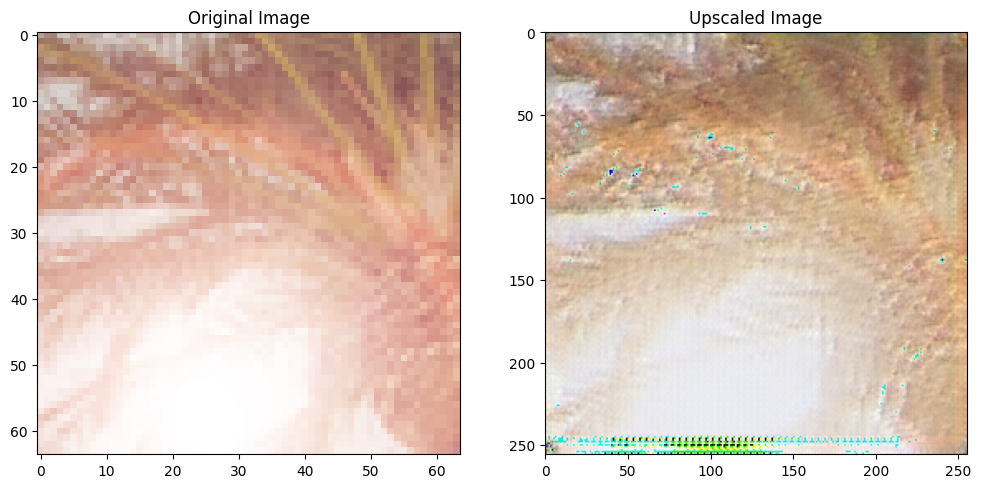

In [31]:
import matplotlib.pyplot as plt

# Function to load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    # The transform should match the preprocessing used during training
    transform = transforms.Compose([
        transforms.ToTensor(),
        # Add any other transformations you used during training
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

# Function to display tensor as image
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0)  # Remove batch dimension
    image = transforms.ToPILImage()(tensor)
    return image

# Load the image
image_path = 'data_dir/0003_5_1_LR.png'  # Replace with your image path
input_image = load_image(image_path).to(device)

# Perform inference
generator.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients
    output_image = start_epoch(input_image)

# Convert output tensor to image
output_image = tensor_to_image(output_image.cpu())  # Move to CPU for PIL conversion

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(Image.open(image_path))
plt.subplot(1, 2, 2)
plt.title("Upscaled Image")
plt.imshow(output_image)
plt.show()
